In [2]:
!pip install -qU huggingface_hub==0.28.1 peft==0.17.0 transformers==4.44.2 sentence-transformers==3.0.1


import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from sentence_transformers import SentenceTransformer
import torch


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 464.1/464.1 kB 10.8 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 503.9/503.9 kB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 97.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 86.3 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 105.3 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 77.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 

2025-10-13 09:20:24.022703: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760347224.223716      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760347224.285469      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
train = pd.read_csv('/kaggle/input/amazon-data/train.csv')
test = pd.read_csv('/kaggle/input/amazon-data/test.csv')
train = train.dropna(subset=['catalog_content', 'price'])
test = test.dropna(subset=['catalog_content'])



In [5]:

train['log_price'] = np.log1p(train['price'])


In [6]:
model_name = "microsoft/deberta-v3-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def preprocess(examples):
    return tokenizer(examples['catalog_content'], padding='max_length', truncation=True, max_length=128)

train_ds = Dataset.from_pandas(train[['catalog_content', 'log_price']].rename(columns={'log_price':'labels'}))
train_ds = train_ds.map(preprocess, batched=True)
train_ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])



tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:551: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Map:   0%|          | 0/75000 [00:00<?, ? examples/s]

In [7]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=1)

pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
training_args = TrainingArguments(
    output_dir="./deberta-price",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    num_train_epochs=8,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=100,
    save_strategy="epoch",
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds
)
trainer.train()


Step,Training Loss
100,1.434800
200,0.895500
300,0.861600
400,0.794600
500,0.685500
600,0.713000
700,0.743300
800,0.689600
900,0.623600
1000,0.667300


TrainOutput(global_step=75000, training_loss=0.2824433128611247, metrics={'train_runtime': 12806.6064, 'train_samples_per_second': 46.851, 'train_steps_per_second': 5.856, 'total_flos': 3.94670117376e+16, 'train_loss': 0.2824433128611247, 'epoch': 8.0})

In [9]:
test_ds = Dataset.from_pandas(test[['catalog_content']])
test_ds = test_ds.map(lambda x: tokenizer(x['catalog_content'], padding='max_length', truncation=True, max_length=128), batched=True)
test_ds.set_format(type='torch', columns=['input_ids', 'attention_mask'])

preds = trainer.predict(test_ds)
preds = preds.predictions.flatten()
test['predicted_price'] = np.expm1(preds)


Map:   0%|          | 0/75000 [00:00<?, ? examples/s]

In [10]:
submission = test[['sample_id', 'predicted_price']]
submission.to_csv('submission.csv', index=False)
print("✅ Saved submission.csv successfully!")
submission.head()


✅ Saved submission.csv successfully!


,sample_id,predicted_price
0,100179,11.638009
1,245611,11.772545
2,146263,17.198736
3,95658,7.290884
4,36806,38.835392


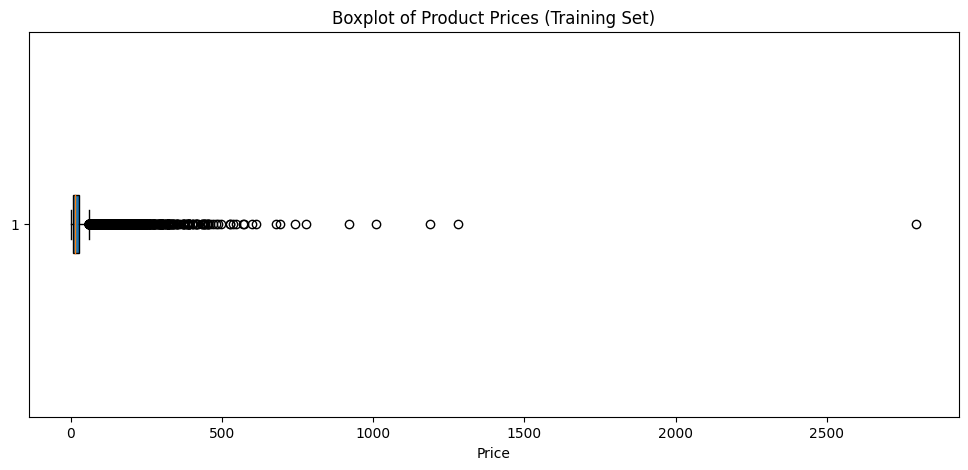

In [17]:
# Block 7: Boxplot for price distribution
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.boxplot(train['price'], vert=False, patch_artist=True, showfliers=True)
plt.xlabel("Price")
plt.title("Boxplot of Product Prices (Training Set)")
plt.show()


In [19]:
# Calculate Q1, Q3 and IQR
Q1 = train['price'].quantile(0.25)
Q3 = train['price'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for "normal" prices
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"Lower bound: {lower_bound}, Upper bound: {upper_bound}")

Lower bound: -25.949999999999996, Upper bound: 61.37


In [20]:
# Filter out outliers
train_clean = train[(train['price'] >= lower_bound) & (train['price'] <= upper_bound)].copy()
print("Original training size:", train.shape[0])
print("Training size after removing outliers:", train_clean.shape[0])


Original training size: 75000
Training size after removing outliers: 69476


In [21]:
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments

# Assuming you already have train_clean from your IQR filtering
train_clean['log_price'] = np.log1p(train_clean['price'])

# Reload tokenizer
model_name = "microsoft/deberta-v3-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Preprocess
def preprocess(examples):
    return tokenizer(examples['catalog_content'], padding='max_length', truncation=True, max_length=128)

train_clean_ds = Dataset.from_pandas(train_clean[['catalog_content', 'log_price']].rename(columns={'log_price':'labels'}))
train_clean_ds = train_clean_ds.map(preprocess, batched=True)
train_clean_ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])


/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:551: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Map:   0%|          | 0/69476 [00:00<?, ? examples/s]

In [39]:
# Load the saved fine-tuned model from the last training
model_path = "/kaggle/working/deberta-price/checkpoint-9375"   # Folder where checkpoints were saved
model = AutoModelForSequenceClassification.from_pretrained(model_path)


In [40]:
training_args = TrainingArguments(
    output_dir="./deberta-price-continued",
    learning_rate=2e-5,  # optionally reduce slightly if fine-tuning further
    per_device_train_batch_size=8,
    num_train_epochs=2,   # more epochs
    weight_decay=0.01,
    logging_dir='./logs-continued',
    logging_steps=100,
    save_strategy="epoch",
    report_to="none"
)


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_clean_ds
)

trainer.train()


Step,Training Loss
100,0.376900
200,0.352900
300,0.334400
400,0.315600
500,0.382200
600,0.363900
700,0.364900
800,0.373500
900,0.358400
1000,0.349300
